# Firebase

In [90]:
import firebase_admin
from firebase_admin import credentials, firestore
from google.cloud.firestore_v1 import Client
from dotenv import load_dotenv

load_dotenv()

cred = credentials.ApplicationDefault()
firebase_admin.initialize_app()

firestore_client: Client = firestore.client()

ValueError: The default Firebase app already exists. This means you called initialize_app() more than once without providing an app name as the second argument. In most cases you only need to call initialize_app() once. But if you do want to initialize multiple apps, pass a second argument to initialize_app() to give each app a unique name.

In [126]:
tracks_ref = firestore_client.collection(u'tracks_clean_tags')
docs = tracks_ref.stream()

In [127]:
import pandas as pd

df = pd.DataFrame([doc.to_dict() for doc in docs])
df.set_index("id", inplace=True)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0bVtnNhxaqhTx56y4kPotO to 7wCmS9TTVUcIhRalDYFgPy
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               50 non-null     int64  
 1   tags              50 non-null     object 
 2   duration          50 non-null     int64  
 3   liveness          50 non-null     float64
 4   valence           50 non-null     float64
 5   artist_genres     50 non-null     object 
 6   mode              50 non-null     int64  
 7   danceability      50 non-null     float64
 8   artist_names      50 non-null     object 
 9   name              50 non-null     object 
 10  tempo             50 non-null     float64
 11  pitches           50 non-null     object 
 12  loudness          50 non-null     float64
 13  energy            50 non-null     float64
 14  acousticness      50 non-null     float64
 15  instrumentalness  50 non-null     float64
 16  time_signa

In [129]:
df

,key,tags,duration,liveness,valence,artist_genres,mode,danceability,artist_names,name,tempo,pitches,loudness,energy,acousticness,instrumentalness,time_signature
id,,,,,,,,,,,,,,,,,
0bVtnNhxaqhTx56y4kPotO,11,"[german, hip-hop, hip hop, rap]",232840,0.1120,0.6830,[german pop],0,0.462,[Alligatoah],Fick ihn doch,175.810,"{'120.29057': [0.359, 0.218, 0.152, 0.155, 0.1...",-5.027,0.878,0.180000,0.000000,4
0bYg9bo50gSsH3LtXe2SQn,7,"[pop, christmas, mariah carey, xmas]",241106,0.0708,0.3500,"[urban contemporary, dance pop]",1,0.336,[Mariah Carey],All I Want for Christmas Is You,150.273,"{'157.84349': [0.104, 0.052, 0.082, 0.334, 1.0...",-7.463,0.627,0.164000,0.000000,4
0lLxYP7Z3j8Xum8VGYEkTJ,6,"[hardcore, comedy, metal, comedy metal, humorc...",194861,0.3380,0.5830,"[comic metal, alternative metal, industrial me...",1,0.506,[Psychostick],From the Heart (I Hate You),149.917,"{'175.31166': [0.182, 0.385, 0.218, 0.192, 0.2...",-9.344,0.467,0.644000,0.022600,3
1SOClUWhOi8vHZYMz3GluK,11,"[alternative, electropop, folk, indie pop, ind...",237720,0.3040,0.4940,"[pop, modern rock, indie poptimism]",0,0.671,[Jaymes Young],Infinity,121.963,"{'213.82677': [0.069, 0.058, 0.349, 0.042, 0.0...",-6.941,0.673,0.148000,0.000053,4
1cKHdTo9u0ZymJdPGSh6nq,10,"[techno, rnb, sad, soul]",241066,0.1630,0.1550,"[pop, dark clubbing, destroy techno, canadian ...",1,0.323,"[The Weeknd, Gesaffelstein]",I Was Never There,113.260,"{'156.11401': [0.032, 0.121, 0.081, 0.13, 0.12...",-4.008,0.737,0.142000,0.000162,4
1jDJFeK9x3OZboIAHsY9k2,6,"[80s, elton john, pop, rock, classic rock]",183440,0.1400,0.7720,"[mellow gold, piano rock, glam rock]",1,0.504,[Elton John],I'm Still Standing,176.808,"{'44.30939': [0.966, 0.762, 0.064, 0.091, 0.18...",-6.863,0.904,0.356000,0.121000,4
1yYr4D1KjhhyDD5bZIiFQy,9,"[metal, metalcore, thrash metal, heavy metal]",302466,0.3460,0.3380,"[groove metal, melodic thrash, metalcore, alte...",1,0.477,[Trivium],In Waves,76.517,"{'67.03016': [1.0, 0.647, 0.216, 0.199, 0.083,...",-3.435,0.940,0.000211,0.051800,4
227jOVNY1MrE5MkUcQRhsk,1,"[metal, symphonic death metal, melodic death m...",352560,0.5940,0.0351,"[symphonic deathcore, blackened deathcore]",0,0.290,[Lorna Shore],Pain Remains I: Dancing Like Flames,125.021,"{'257.7415': [1.0, 0.802, 0.257, 0.23, 0.262, ...",-4.361,0.799,0.000166,0.894000,4
27RYrbL6S02LNVhDWVl38b,2,"[avantgarde pop, post-revolutionary pop song, ...",214333,0.7180,0.4140,"[album rock, art rock, experimental, beatlesqu...",1,0.321,"[Yoko Ono, John Lennon]",Happy Xmas (War Is Over) - Remastered 2010,146.172,"{'95.95605': [0.096, 0.091, 0.086, 0.079, 0.29...",-10.023,0.640,0.280000,0.000000,3


In [130]:
tolower = lambda s: s.lower()
flatmap = lambda list_of_lists: [item for l in list_of_lists for item in l]
tags = pd.Series(flatmap(df[~df["tags"].isna()]["tags"].values.tolist())).apply(tolower).drop_duplicates()
tags.info()

<class 'pandas.core.series.Series'>
Int64Index: 128 entries, 0 to 186
Series name: None
Non-Null Count  Dtype 
--------------  ----- 
128 non-null    object
dtypes: object(1)
memory usage: 2.0+ KB


In [111]:
tags

0               german
1              hip-hop
2              hip hop
3                  rap
4                  pop
            ...       
181    christmas songs
183          mistagged
184         remastered
185         fight club
186          post-punk
Length: 128, dtype: object

In [151]:
pitch_symbol = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]


def pitch_trans(p):
    pitch_frequency = list()
    for timestamp in p:
        pitch_dict = {"timestamp": float(timestamp)}
        for i in range(0, len(p[timestamp])):
            pitch_dict[pitch_symbol[i]] = p[timestamp][i]
        pitch_frequency.append(pitch_dict)
    return pitch_frequency

def pitches_to_dataframe(p):
    return pd.DataFrame(p).sort_values(by=["timestamp"])

pitches = df["pitches"].apply(pitch_trans)
df["pitches"] = pitches

TypeError: list indices must be integers or slices, not dict

In [152]:
first_song = pitches_to_dataframe(pitches.iloc[0])
df

,key,tags,duration,liveness,valence,artist_genres,mode,danceability,artist_names,name,tempo,pitches,loudness,energy,acousticness,instrumentalness,time_signature
id,,,,,,,,,,,,,,,,,
0bVtnNhxaqhTx56y4kPotO,11,"[german, hip-hop, hip hop, rap]",232840,0.1120,0.6830,[german pop],0,0.462,[Alligatoah],Fick ihn doch,175.810,"[{'timestamp': '120.29057', 'C': 0.359, 'C#': ...",-5.027,0.878,0.180000,0.000000,4
0bYg9bo50gSsH3LtXe2SQn,7,"[pop, christmas, mariah carey, xmas]",241106,0.0708,0.3500,"[urban contemporary, dance pop]",1,0.336,[Mariah Carey],All I Want for Christmas Is You,150.273,"[{'timestamp': '157.84349', 'C': 0.104, 'C#': ...",-7.463,0.627,0.164000,0.000000,4
0lLxYP7Z3j8Xum8VGYEkTJ,6,"[hardcore, comedy, metal, comedy metal, humorc...",194861,0.3380,0.5830,"[comic metal, alternative metal, industrial me...",1,0.506,[Psychostick],From the Heart (I Hate You),149.917,"[{'timestamp': '175.31166', 'C': 0.182, 'C#': ...",-9.344,0.467,0.644000,0.022600,3
1SOClUWhOi8vHZYMz3GluK,11,"[alternative, electropop, folk, indie pop, ind...",237720,0.3040,0.4940,"[pop, modern rock, indie poptimism]",0,0.671,[Jaymes Young],Infinity,121.963,"[{'timestamp': '213.82677', 'C': 0.069, 'C#': ...",-6.941,0.673,0.148000,0.000053,4
1cKHdTo9u0ZymJdPGSh6nq,10,"[techno, rnb, sad, soul]",241066,0.1630,0.1550,"[pop, dark clubbing, destroy techno, canadian ...",1,0.323,"[The Weeknd, Gesaffelstein]",I Was Never There,113.260,"[{'timestamp': '156.11401', 'C': 0.032, 'C#': ...",-4.008,0.737,0.142000,0.000162,4
1jDJFeK9x3OZboIAHsY9k2,6,"[80s, elton john, pop, rock, classic rock]",183440,0.1400,0.7720,"[mellow gold, piano rock, glam rock]",1,0.504,[Elton John],I'm Still Standing,176.808,"[{'timestamp': '44.30939', 'C': 0.966, 'C#': 0...",-6.863,0.904,0.356000,0.121000,4
1yYr4D1KjhhyDD5bZIiFQy,9,"[metal, metalcore, thrash metal, heavy metal]",302466,0.3460,0.3380,"[groove metal, melodic thrash, metalcore, alte...",1,0.477,[Trivium],In Waves,76.517,"[{'timestamp': '67.03016', 'C': 1.0, 'C#': 0.6...",-3.435,0.940,0.000211,0.051800,4
227jOVNY1MrE5MkUcQRhsk,1,"[metal, symphonic death metal, melodic death m...",352560,0.5940,0.0351,"[symphonic deathcore, blackened deathcore]",0,0.290,[Lorna Shore],Pain Remains I: Dancing Like Flames,125.021,"[{'timestamp': '257.7415', 'C': 1.0, 'C#': 0.8...",-4.361,0.799,0.000166,0.894000,4
27RYrbL6S02LNVhDWVl38b,2,"[avantgarde pop, post-revolutionary pop song, ...",214333,0.7180,0.4140,"[album rock, art rock, experimental, beatlesqu...",1,0.321,"[Yoko Ono, John Lennon]",Happy Xmas (War Is Over) - Remastered 2010,146.172,"[{'timestamp': '95.95605', 'C': 0.096, 'C#': 0...",-10.023,0.640,0.280000,0.000000,3


<AxesSubplot: xlabel='timestamp'>

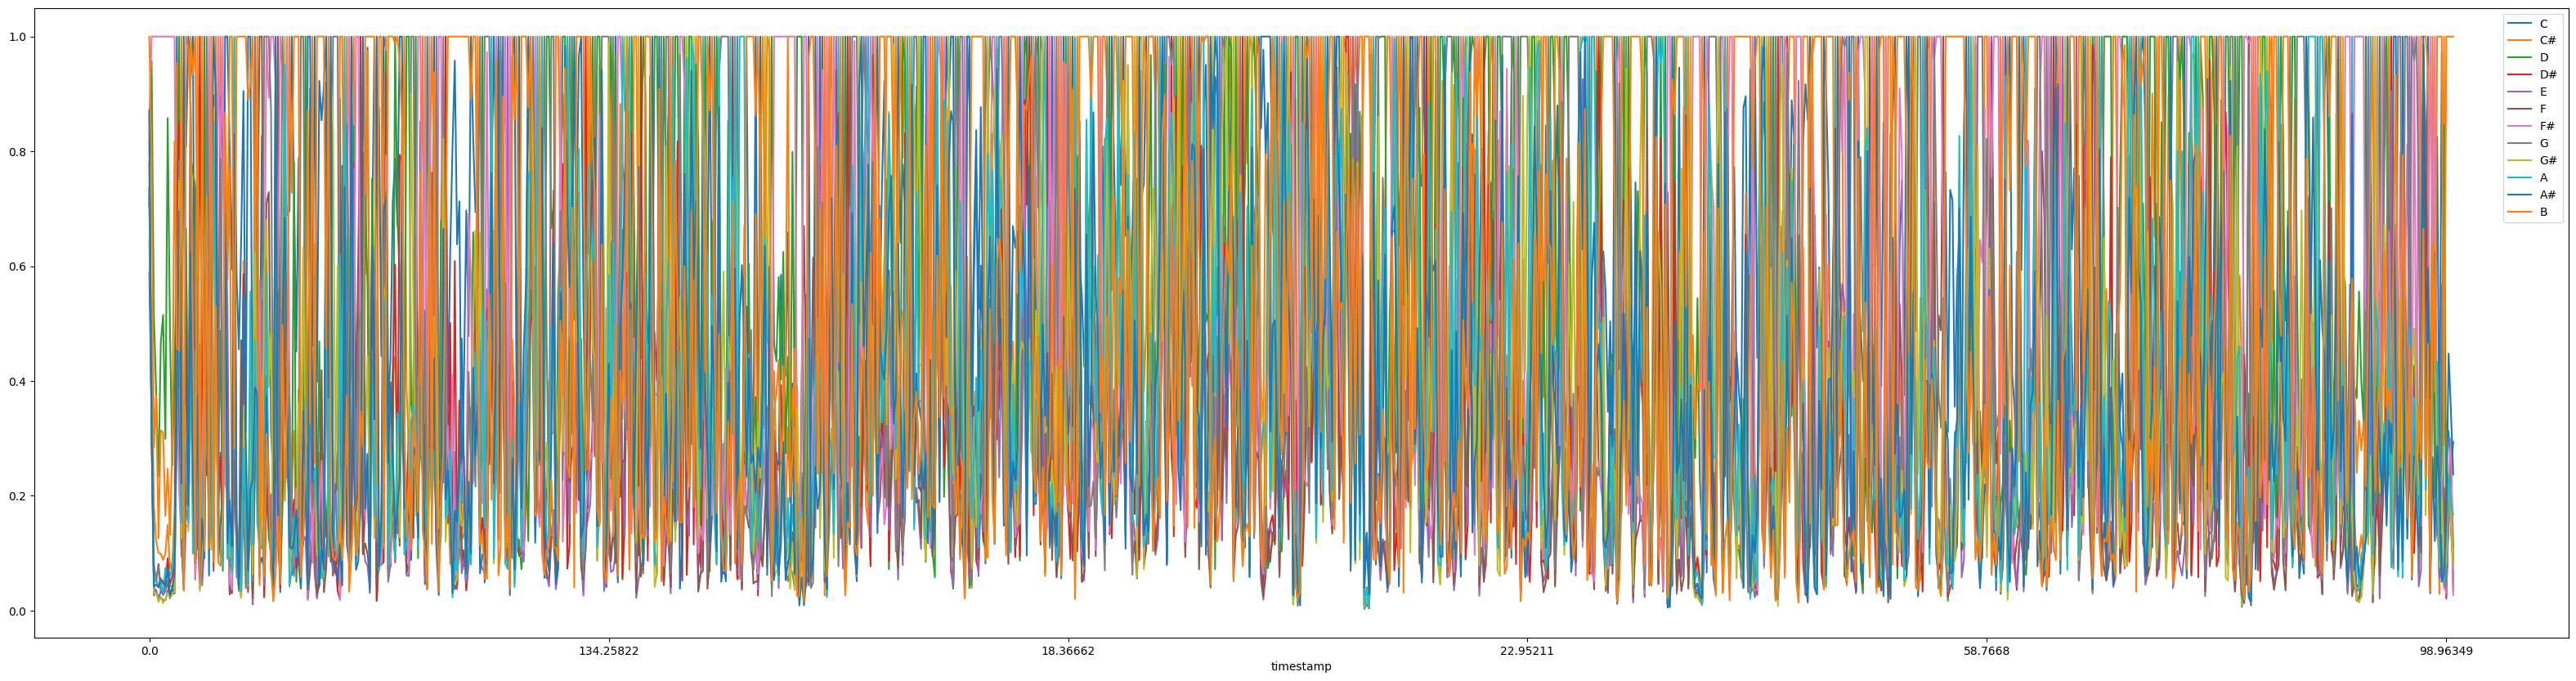

In [146]:
first_song.plot(x="timestamp", figsize=(40, 10))

In [159]:
from typing import List

from typing import Dict


def max_of_pitches(freq: List[Dict[str, float]], pitch: chr):
    return max([item[pitch] for item in freq])

def min_of_pitches(freq: List[Dict[str, float]], pitch: chr):
    return min([item[pitch] for item in freq])

for sym in pitch_symbol:
    df.insert(len(df.columns), f"{sym}_max", [max_of_pitches(item, sym) for item in df["pitches"]])
    df.insert(len(df.columns), f"{sym}_min", [min_of_pitches(item, sym) for item in df["pitches"]])
df

,key,tags,duration,liveness,valence,artist_genres,mode,danceability,artist_names,name,...,G_max,G_min,G#_max,G#_min,A_max,A_min,A#_max,A#_min,B_max,B_min
id,,,,,,,,,,,,,,,,,,,,,
0bVtnNhxaqhTx56y4kPotO,11,"[german, hip-hop, hip hop, rap]",232840,0.1120,0.6830,[german pop],0,0.462,[Alligatoah],Fick ihn doch,...,1.0,0.004,1.000,0.005,1.0,0.004,1.0,0.005,1.0,0.014
0bYg9bo50gSsH3LtXe2SQn,7,"[pop, christmas, mariah carey, xmas]",241106,0.0708,0.3500,"[urban contemporary, dance pop]",1,0.336,[Mariah Carey],All I Want for Christmas Is You,...,1.0,0.004,1.000,0.002,1.0,0.008,1.0,0.004,1.0,0.001
0lLxYP7Z3j8Xum8VGYEkTJ,6,"[hardcore, comedy, metal, comedy metal, humorc...",194861,0.3380,0.5830,"[comic metal, alternative metal, industrial me...",1,0.506,[Psychostick],From the Heart (I Hate You),...,1.0,0.007,1.000,0.003,1.0,0.002,1.0,0.004,1.0,0.001
1SOClUWhOi8vHZYMz3GluK,11,"[alternative, electropop, folk, indie pop, ind...",237720,0.3040,0.4940,"[pop, modern rock, indie poptimism]",0,0.671,[Jaymes Young],Infinity,...,1.0,0.010,1.000,0.013,1.0,0.013,1.0,0.017,1.0,0.009
1cKHdTo9u0ZymJdPGSh6nq,10,"[techno, rnb, sad, soul]",241066,0.1630,0.1550,"[pop, dark clubbing, destroy techno, canadian ...",1,0.323,"[The Weeknd, Gesaffelstein]",I Was Never There,...,1.0,0.002,1.000,0.004,1.0,0.002,1.0,0.001,1.0,0.005
1jDJFeK9x3OZboIAHsY9k2,6,"[80s, elton john, pop, rock, classic rock]",183440,0.1400,0.7720,"[mellow gold, piano rock, glam rock]",1,0.504,[Elton John],I'm Still Standing,...,1.0,0.023,1.000,0.026,1.0,0.019,1.0,0.037,1.0,0.014
1yYr4D1KjhhyDD5bZIiFQy,9,"[metal, metalcore, thrash metal, heavy metal]",302466,0.3460,0.3380,"[groove metal, melodic thrash, metalcore, alte...",1,0.477,[Trivium],In Waves,...,1.0,0.018,1.000,0.055,1.0,0.010,1.0,0.006,1.0,0.012
227jOVNY1MrE5MkUcQRhsk,1,"[metal, symphonic death metal, melodic death m...",352560,0.5940,0.0351,"[symphonic deathcore, blackened deathcore]",0,0.290,[Lorna Shore],Pain Remains I: Dancing Like Flames,...,1.0,0.007,1.000,0.006,1.0,0.005,1.0,0.004,1.0,0.010
27RYrbL6S02LNVhDWVl38b,2,"[avantgarde pop, post-revolutionary pop song, ...",214333,0.7180,0.4140,"[album rock, art rock, experimental, beatlesqu...",1,0.321,"[Yoko Ono, John Lennon]",Happy Xmas (War Is Over) - Remastered 2010,...,1.0,0.010,1.000,0.042,1.0,0.031,1.0,0.017,1.0,0.018
